In [22]:
!pip install split-folders tqdm

In [23]:
!pwd

/content


In [24]:
% cd ../
!cp -r '/content/drive/My Drive/image/DATA_CHAMBER_2020-03-03.zip' '/content'

/


In [25]:
% cd content/
!unzip -q 'DATA_CHAMBER_2020-03-03.zip'

/content


In [50]:
import split_folders

split_folders.ratio('DATA_CHAMBER_2020-03-03', output="dataset", ratio=(.8, .2)) 


Copying files: 8324 files [00:02, 3335.43 files/s]


In [0]:
!rm -rf dataset

In [33]:
% cd ../../

/content


In [30]:
% cd not/test_set/2C/

/content/not/test_set/2C


In [31]:
!ls -l | grep ^- | wc -l

558


'dataset' folder is used now

information:
  + original source: DATA_CHAMBER_2020-03-03
  + dataset contains: ~ 8320 imgs.
            - test_set
              --2C
              --3C
              --3C
              --4C
            - training_set
              --2C
              --3C
              --4C
  + training set is choose (in ordered) from the original DATA_CHAMBER_2020-03-03 ( training set accounts for ~80% of original data source)
  + test set is the rest of the original data source. ( which is 20%)

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [0]:
transform = transforms.Compose([transforms.Resize((80,120)),
                                transforms.CenterCrop((64,85)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize( [0.5], [0.5])])

In [0]:
training_dataset = datasets.ImageFolder(root='dataset/training_set',transform=transform)
validation_dataset = datasets.ImageFolder(root='dataset/test_set',transform=transform)

training_loader =  torch.utils.data.DataLoader(dataset=training_dataset,  batch_size=100, shuffle=True,drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,  batch_size=100, shuffle=True, drop_last=True)

In [8]:
validation_dataset

Dataset ImageFolder
    Number of datapoints: 1666
    Root location: dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(80, 120), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 85))
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [35]:
validation_dataset

Dataset ImageFolder
    Number of datapoints: 1667
    Root location: not/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(80, 120), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 85))
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [9]:
print(training_dataset.class_to_idx)

{'2C': 0, '3C': 1, '4C': 2}


In [10]:
print(training_loader.dataset,'\n', validation_loader.dataset)

Dataset ImageFolder
    Number of datapoints: 6658
    Root location: dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(80, 120), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 85))
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           ) 
 Dataset ImageFolder
    Number of datapoints: 1666
    Root location: dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(80, 120), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 85))
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [0]:
data_iter = iter(training_loader)
images, labels = data_iter.next()

In [0]:
training_loader

Text(0.5, 1.0, '1')

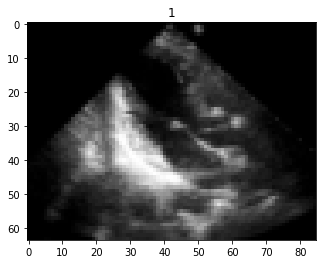

In [55]:
im = images[0][0]
plt.imshow(im,cmap='gray')
plt.title(labels[0].item())

In [0]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out): # nn with 2 hidden layers
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x


In [57]:
model = Classifier(5440, 1000, 50, 3)
model

Classifier(
  (linear1): Linear(in_features=5440, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=3, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [62]:
from collections import OrderedDict

epochs = 5
running_loss_his = []
running_corrects_his = []
val_running_loss_his = []
val_running_corrects_his = []
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss =0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) # flatten to 1x5440
    # print('input shape: ', inputs.shape) 
    outputs = model(inputs)
    loss = criterion(outputs, labels) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    # print('running_corrects = ', running_corrects)
    running_loss += loss.item()

  else:
    with torch.no_grad(): # bcz this the val set, no need to cal grad() here
      for val_inputs , val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
      
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        # print('val_running_corrects = ', val_running_corrects)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_his.append(epoch_loss)
    running_corrects_his.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    # print('val_running_corrects = ', val_running_corrects)
    # print('length_val_loader = ', len(validation_loader))
    val_running_loss_his.append(val_epoch_loss)
    val_running_corrects_his.append(val_epoch_acc)

    print('epoch ', e, '   training loss: ', epoch_loss, '      acc: ', epoch_acc.item())
    print('epoch ', e, '   validation loss: ', val_epoch_loss, '      acc: ', val_epoch_acc.item())

    state = OrderedDict([
        ('state_dict', model.state_dict()),
        ('optimizer', optimizer.state_dict()),
        ('epoch', e),
        ('accuracy', val_epoch_acc),
    ])
    torch.save(state, '/content/drive/My Drive/image/result_0/model__1.pth')
    


epoch  0    training loss:  0.3909019563685764       acc:  92.30303192138672
epoch  0    validation loss:  0.12069310783408582       acc:  96.0
epoch  1    training loss:  0.13955596941664364       acc:  97.51515197753906
epoch  1    validation loss:  0.03769326815381646       acc:  98.8125
epoch  2    training loss:  0.04235424025153572       acc:  99.45454406738281
epoch  2    validation loss:  0.022564961458556354       acc:  99.3125
epoch  3    training loss:  0.3683666057150924       acc:  93.09091186523438
epoch  3    validation loss:  0.13857328984886408       acc:  94.8125
epoch  4    training loss:  0.07548996416682546       acc:  98.75757598876953
epoch  4    validation loss:  0.0054777747427579015       acc:  99.9375


In [19]:
!pwd

/content


In [63]:
from PIL import Image

img_tensor = Image.open('/content/From20Frs__BAU 67T RCA__3C__IMG-0042-00001.dcm_5.jpg') # class 3C


img_tensor = img_tensor.convert('1') # only select 1 channel
img_tensor = transform(img_tensor)

_img = img_tensor.reshape(1, -1)

_, num = torch.max(model(_img), 1)
num

tensor([1])